In [1]:
import pynucastro as pyna
import matplotlib.pyplot as plt
import numpy as np
from pynucastro.screening import potekhin_1998
from scipy.integrate import solve_ivp

In [2]:
rl = pyna.ReacLibLibrary()

all_nuclei = ['he4', 'c12', 'o16', 'ne20', 'mg24', 'si28', 's32', 'ar36', 'ca40', 'ti44', 'cr48', 'fe52', 'ni56']
all_nuclei += ['h1', 'al27', 'p31', 'cl35', 'k39', 'sc43', 'v47', 'mn51', 'co55']

fwd = rl.linking_nuclei(nuclist=all_nuclei, with_reverse=False)

inv = []
for r in fwd.get_rates():
    if not r.weak:
        t = pyna.DerivedRate(r, compute_Q=False, use_pf=True, use_unreliable_spins=True)
        inv.append(t)

inv = pyna.Library(rates=inv)

tot = fwd + inv
rc = pyna.PythonNetwork(libraries=tot, symmetric_screening=False, do_screening=True)
rc.make_ap_pg_approx()
rc.remove_nuclei(['h1', 'al27', 'p31', 'cl35', 'k39', 'sc43', 'v47', 'mn51', 'co55'])

using approximate rate Mg24 + He4 ⟶ Si28 + 𝛾
using approximate rate Si28 ⟶ Mg24 + He4
using approximate rate Si28 + He4 ⟶ S32 + 𝛾
using approximate rate S32 ⟶ Si28 + He4
using approximate rate S32 + He4 ⟶ Ar36 + 𝛾
using approximate rate Ar36 ⟶ S32 + He4
using approximate rate Ar36 + He4 ⟶ Ca40 + 𝛾
using approximate rate Ca40 ⟶ Ar36 + He4
using approximate rate Ca40 + He4 ⟶ Ti44 + 𝛾
using approximate rate Ti44 ⟶ Ca40 + He4
using approximate rate Ti44 + He4 ⟶ Cr48 + 𝛾
using approximate rate Cr48 ⟶ Ti44 + He4
using approximate rate Cr48 + He4 ⟶ Fe52 + 𝛾
using approximate rate Fe52 ⟶ Cr48 + He4
using approximate rate Fe52 + He4 ⟶ Ni56 + 𝛾
using approximate rate Ni56 ⟶ Fe52 + He4
removing rate Mg24 + He4 ⟶ Si28 + 𝛾
removing rate Mg24 + He4 ⟶ p + Al27
removing rate Al27 + p ⟶ Si28 + 𝛾
removing rate Si28 ⟶ He4 + Mg24
removing rate Si28 ⟶ p + Al27
removing rate Al27 + p ⟶ He4 + Mg24
removing rate Si28 + He4 ⟶ S32 + 𝛾
removing rate Si28 + He4 ⟶ p + P31
removing rate P31 + p ⟶ S32 + 𝛾
removing r

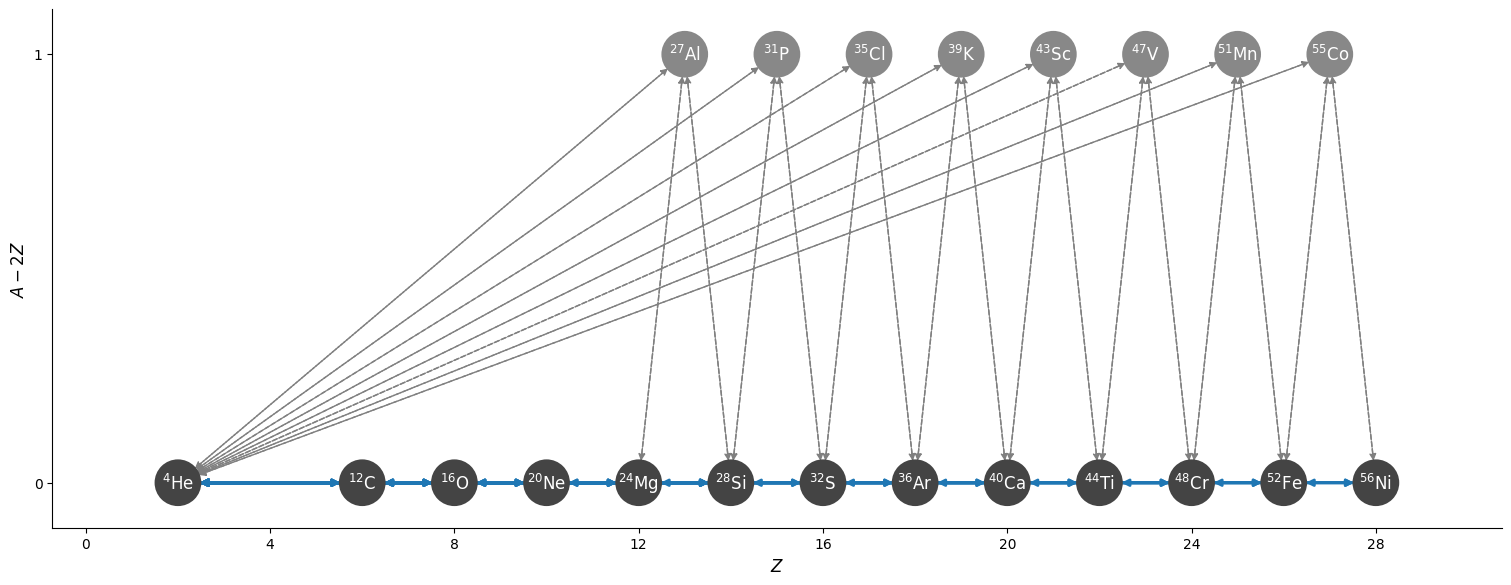

In [3]:
fig = rc.plot(rotated=True, size=(1500,600), curved_edges=False)

In [4]:
rc.write_network('approx13.py')
print(tot)

3 He4 ⟶ C12 + 𝛾                [Q =   7.28 MeV] (3 He4 --> C12 <fy05_reaclib__>)
C12 + He4 ⟶ O16 + 𝛾            [Q =   7.16 MeV] (C12 + He4 --> O16 <nac2_reaclib__>)
C12 + C12 ⟶ He4 + Ne20         [Q =   4.62 MeV] (C12 + C12 --> He4 + Ne20 <cf88_reaclib__>)
O16 + He4 ⟶ Ne20 + 𝛾           [Q =   4.73 MeV] (O16 + He4 --> Ne20 <co10_reaclib__>)
O16 + C12 ⟶ He4 + Mg24         [Q =   6.77 MeV] (O16 + C12 --> He4 + Mg24 <cf88_reaclib__>)
O16 + C12 ⟶ p + Al27           [Q =   5.17 MeV] (O16 + C12 --> p + Al27 <cf88_reaclib__>)
O16 + O16 ⟶ He4 + Si28         [Q =   9.59 MeV] (O16 + O16 --> He4 + Si28 <cf88_reaclib__>)
O16 + O16 ⟶ p + P31            [Q =   7.68 MeV] (O16 + O16 --> p + P31 <cf88_reaclib__>)
Ne20 + He4 ⟶ Mg24 + 𝛾          [Q =   9.32 MeV] (Ne20 + He4 --> Mg24 <il10_reaclib__>)
Ne20 + C12 ⟶ He4 + Si28        [Q =  12.02 MeV] (Ne20 + C12 --> He4 + Si28 <rolf_reaclib__>)
Ne20 + C12 ⟶ p + P31           [Q =  10.10 MeV] (Ne20 + C12 --> p + P31 <rolf_reaclib__>)
Mg24 + He4 ⟶ Si28 + 𝛾  

/var/data/python/lib/python3.12/site-packages/pynucastro/rates/derived_rate.py:135: UserWarning: C12 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))


In [5]:
import approx13

In [6]:
X0 = np.zeros(approx13.nnuc)
X0[approx13.jhe4] = 1.0
X0[approx13.jc12] = 0.0
X0[approx13.jo16] = 0.0
X0[approx13.jne20] = 0.0
X0[approx13.jmg24] = 0.0
X0[approx13.jsi28] = 0.0
X0[approx13.js32] = 0.0
X0[approx13.jar36] = 0.0
X0[approx13.jca40] = 0.0
X0[approx13.jti44] = 0.0
X0[approx13.jcr48] = 0.0
X0[approx13.jfe52] = 0.0
X0[approx13.jni56] = 0.0

X0 /= np.sum(X0)
Y0 = X0/approx13.A

In [7]:
rho = 1.0e8 
T = 7.0e9
Ye = approx13.ye(Y0)

In [8]:
tmin = 1.0e-9
tmax = 1.0e-3
sol =  solve_ivp(approx13.rhs, [0, tmax], Y0, method="BDF",
                dense_output=True, args=(rho, T, potekhin_1998), rtol=1.e-10, atol=1.e-10, jac=approx13.jacobian)

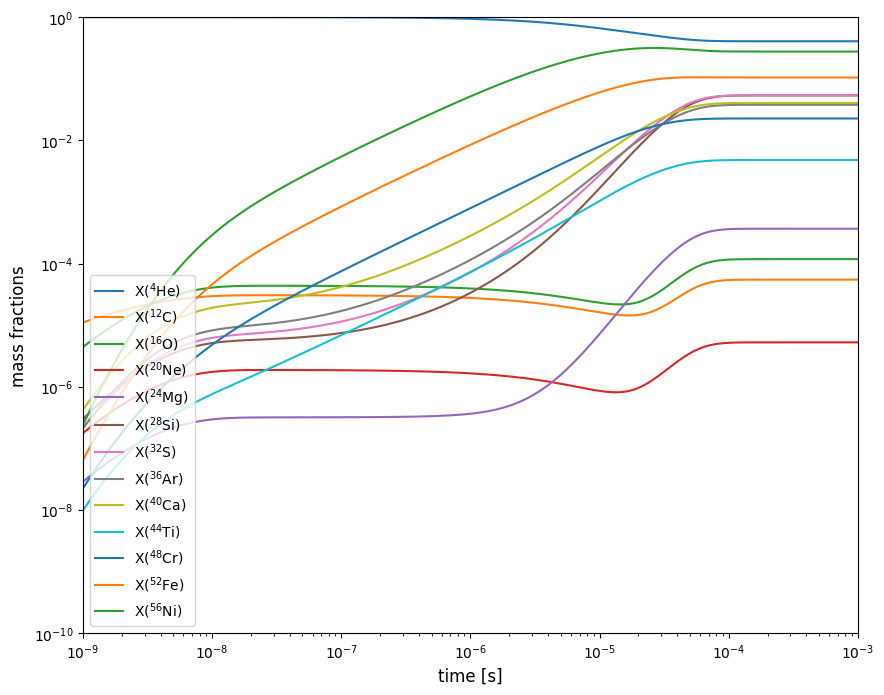

In [9]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for i in range(approx13.nnuc):
    ax.loglog(sol.t, sol.y[i,:] * approx13.A[i], label=rf"X(${pyna.Nucleus(approx13.names[i]).pretty}$)")

ax.set_xlim(tmin, tmax)
ax.legend(loc="lower left")
ax.set_ylim(1.e-10, 1.0)
ax.set_xlabel(f"time [s]", fontsize=12)
ax.set_ylabel(f"mass fractions", fontsize=12)
fig.set_size_inches((10, 8))

## Create an NSE Solver

In [10]:
nse = pyna.NSENetwork(rates=rc.get_rates())

In [11]:
comp = nse.get_comp_nse(rho, T, Ye, init_guess=(-3.5, -14.0), use_coulomb_corr=True)

print("From NSE calculation:")
# print(comp)
for key, value in comp.X.items():
    print("{0}: {1:.10f}".format(key, value))

print(" ")

print("From integration:")
for i in range(approx13.nnuc):
    print("X({0}): {1:.10f}".format(approx13.names[i], sol.y[i,-1]*approx13.A[i]))

From NSE calculation:
He4: 0.4054196105
C12: 0.0000548141
O16: 0.0001177780
Ne20: 0.0000052464
Mg24: 0.0003669881
Si28: 0.0535114604
S32: 0.0537160365
Ar36: 0.0377211610
Ca40: 0.0403726933
Ti44: 0.0047821939
Cr48: 0.0226236193
Fe52: 0.1043079786
Ni56: 0.2770004199
 
From integration:
X(He4): 0.4055869802
X(C12): 0.0000547718
X(O16): 0.0001177568
X(Ne20): 0.0000052481
X(Mg24): 0.0003672491
X(Si28): 0.0535708762
X(S32): 0.0538118872
X(Ar36): 0.0377939964
X(Ca40): 0.0404542457
X(Ti44): 0.0047937219
X(Cr48): 0.0226219495
X(Fe52): 0.1045754104
X(Ni56): 0.2762459068


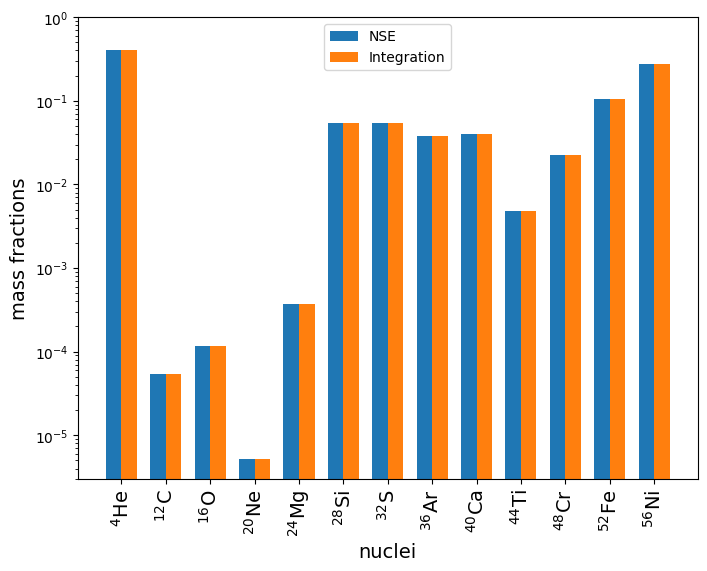

In [12]:
x = np.arange(len(approx13.names))
width = 0.35

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.bar(x - width/2.0, list(comp.X.values()), width, label = 'NSE')
ax.bar(x + width/2.0, sol.y[:,-1] * approx13.A, width, label = 'Integration')
ax.set_xlabel("nuclei", fontsize=14)
ax.set_xticks(x, labels=[f"${n.pretty}$" for n in comp.X.keys()], rotation=90, fontsize=14)
ax.set_ylabel("mass fractions", fontsize=14)
ax.legend(fontsize=14)
ax.set_yscale("log")
ax.set_ylim(ymax = 1)
ax.legend(loc="best")

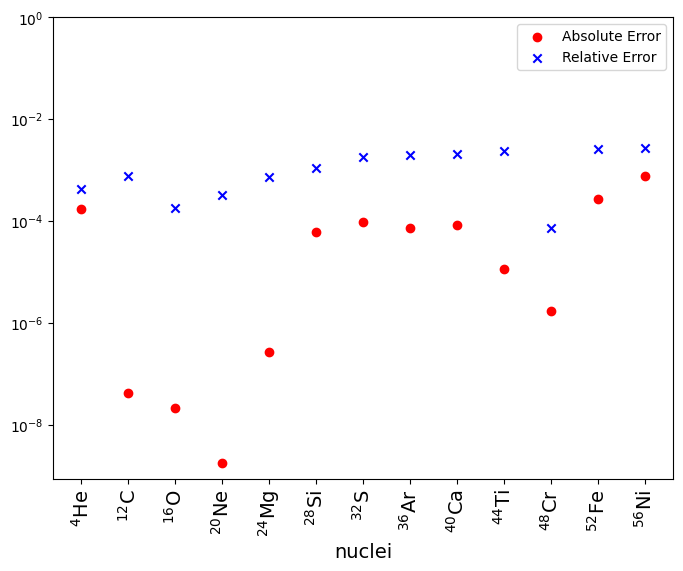

In [13]:
# Difference graph
X_net = {}

for i in range(approx13.nnuc):
    X_net[pyna.Nucleus(approx13.names[i])] = sol.y[i,-1]*approx13.A[i]

X_nse = comp.X

diff = {}
diff_rel = {}

for i in range(approx13.nnuc):
    nuc = pyna.Nucleus(approx13.names[i])
    diff[nuc] = np.abs(X_net[nuc] - X_nse[nuc])
    diff_rel[nuc] = np.abs(X_net[nuc] - X_nse[nuc])/X_net[nuc]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(x, diff.values(), label='Absolute Error', marker='o', color='r')
ax.scatter(x, diff_rel.values(), label='Relative Error', marker ='x', color='b')
ax.set_xticks(x, labels=[f"${n.pretty}$" for n in diff.keys()], rotation=90, fontsize=14)
ax.set_xlabel("nuclei", fontsize=14)
ax.set_yscale("log")
ax.legend(fontsize=14)
ax.set_ylim(ymax = 1)
ax.legend(loc="best")